# AdaBoost

In this notebook, we will use an AdaBoost boosting technique on a decision stump as our classifier. We will then try to optimize the number of estimators using cross-validation. 

In [1]:
## Import all the necessary packages

## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("darkgrid")

## To do a train-test split and to perform cross-validation
from sklearn.model_selection import train_test_split, StratifiedKFold

## Performace metrics for classification algorithms
from sklearn.metrics import roc_auc_score,accuracy_score

## To use a decision stump 
from sklearn.tree import DecisionTreeClassifier

## Import Adaboost
from sklearn.ensemble import AdaBoostClassifier

Now, let's do a train-test split. We use a random seed to be consistent with the other files. 

In [2]:
## Import cleaned CSV (no date information)
cmm_pa_clf_read = pd.read_csv("../Data/cmm_pa_clf.csv",index_col = 0)

## Separate the features from the output
cmm_pa_clf_data = cmm_pa_clf_read.drop(columns = 'pa_approved').copy()
cmm_pa_clf_target = cmm_pa_clf_read['pa_approved'].copy()

## Train-test split
X_train,X_test,y_train,y_test= train_test_split(cmm_pa_clf_data, cmm_pa_clf_target, test_size = 0.2, 
                                             random_state = 10475, shuffle = True,
                                            stratify = cmm_pa_clf_target)

## k-fold cross validation to tune the hyperparameter
kfold = StratifiedKFold(5, shuffle=True, random_state=10475)

# Tuning n_estimators

In [3]:
## Maximum value of n_estimators
max_n_estimators = 20;
n_estimators_list = range(1,max_n_estimators+1)

## To store the cross-validation accuracy and auc scores for the boosting algorithm. 
ada_cv_accs = np.zeros((5,max_n_estimators))
ada_cv_aucs = np.zeros((5,max_n_estimators))

i = 0; # To keep track of the cross-validation set index;
for train_index, test_index in kfold.split(X_train,y_train):
    
    #Make cross-validation sets
    X_train_train = X_train.iloc[train_index];
    X_holdout = X_train.iloc[test_index,:];
    y_train_train = y_train.iloc[train_index];
    y_holdout = y_train.iloc[test_index];
    
    j = 0; #To keep track of the n_estimator index;
    for n_estimators in n_estimators_list:
        
        #Create an AdaBoost classifier object
        ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                                 n_estimators=n_estimators,
                                 algorithm='SAMME.R',
                                 random_state=10475)
        
        # Fit the cross-validation training data
        ada.fit(X_train_train,y_train_train)
        
        # Make predictions on the cross-validation holdout data
        # and store the accuracy and AUC scores
        ada_cv_accs[i,j] = accuracy_score(y_holdout, ada.predict(X_holdout));
        ada_cv_aucs[i,j] = roc_auc_score(y_holdout,ada.predict_proba(X_holdout)[:,1]);
        j += 1;
    i += 1;

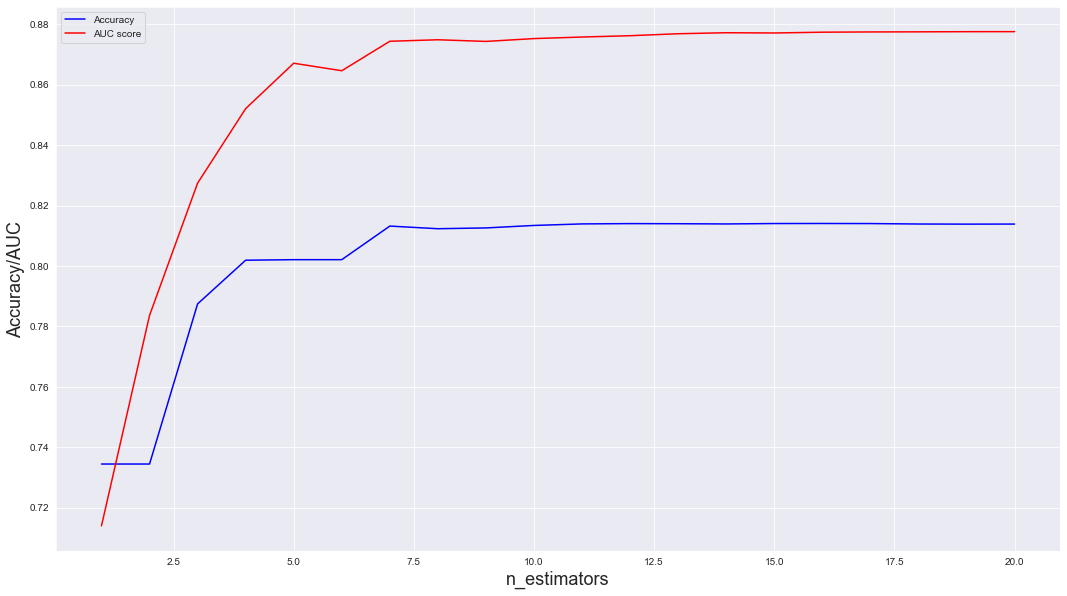

In [4]:
## Average Accuracy and AUC score
ada_acc_mean = ada_cv_accs.mean(0)
ada_auc_mean = ada_cv_aucs.mean(0)

#Plot the Accuracy/AUC vs depth
plt.figure(figsize=(18,10));
plt.plot(n_estimators_list,ada_acc_mean,'b')
plt.plot(n_estimators_list,ada_auc_mean,'r')
plt.legend(["Accuracy","AUC score"])
plt.xlabel("n_estimators",fontsize=18)
plt.ylabel("Accuracy/AUC",fontsize=18)
plt.show()

Using the above graph, it looks like the optimal number of decision stumps to use is **n_estimators = 7** and which leads to Accuracy = 0.813 and AUC = 0.874. 